In [30]:
import os
import pandas as pd

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%run ../content/drive/MyDrive/MLC-Seq-main/modules/utils.ipynb
%run ../content/drive/MyDrive/MLC-Seq-main/modules/ladder_separation.ipynb
%run ../content/drive/MyDrive/MLC-Seq-main/modules/homology_search.ipynb
%run ../content/drive/MyDrive/MLC-Seq-main/modules/mass_sum.ipynb
%run ../content/drive/MyDrive/MLC-Seq-main/modules/gap_fill.ipynb
%run ../content/drive/MyDrive/MLC-Seq-main/modules/ladder_complementation.ipynb

# Control

In [45]:
import os
import pandas as pd


path = '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/'
dir_list = os.listdir(path)
control_files = [path+f for f in dir_list if os.path.isfile(os.path.join(path, f))] # Ensure only files are included
print(control_files)
control_files.sort()

dfs_ctrl = [load_data(f) for f in control_files if load_data(f) is not None] # Skip None results from load_data
dfs_ctrl = [dftmp[dftmp.Mass>23000] for dftmp in dfs_ctrl]
max_rt = max([dftmp.RT.max() for dftmp in dfs_ctrl])
max_vol = max([dftmp.Vol.max() for dftmp in dfs_ctrl])
dfs_updated = list()
for dftmp in dfs_ctrl:
    dftmp.RT *= max_rt/dftmp.RT.max()
    dftmp.Vol *= max_vol/dftmp.Vol.max()
    dfs_updated.append(dftmp)
df_ctrl = pd.concat(dfs_updated)
df_ctrl = drop_dups(df_ctrl)
df_ctrl.shape


['/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/tRNA_total_Control_3.xlsx', '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/tRNA_total_Control_2.xlsx', '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/tRNA_total_Control_1.xlsx', '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/tRNA_total_Control_4.xlsx', '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/Control/tRNA_total_Control_5.xlsx']


KeyError: "['RT'] not in index"

In [46]:

dfs_ctrl = [load_data(f) for f in control_files]
dfs_ctrl = [dftmp[dftmp.Mass>23000] for dftmp in dfs_ctrl]
max_rt = max([dftmp.RT.max() for dftmp in dfs_ctrl])
max_vol = max([dftmp.Vol.max() for dftmp in dfs_ctrl])
dfs_updated = list()
for dftmp in dfs_ctrl:
    dftmp.RT *= max_rt/dftmp.RT.max()
    dftmp.Vol *= max_vol/dftmp.Vol.max()
    dfs_updated.append(dftmp)
df_ctrl = pd.concat(dfs_updated)
df_ctrl = drop_dups(df_ctrl)
df_ctrl.shape

KeyError: "['RT'] not in index"

In [11]:
plotly_zone(df_ctrl, y='Vol')

In [15]:
f = '/content/drive/MyDrive/MLC-Seq-main/statics/total_tRNA_seqs_base.xlsx'
df_seqbase = pd.read_excel(f)
df_seqbase = df_seqbase.rename(columns={'Monoisotopic Mass (full length)': 'Mass1',
                                        'Monoisotopic Mass (CC-tailed)': 'Mass2',
                                        'Monoisotopic Mass (C-tailed)': 'Mass3',
                                        'AminoAcid & CCA': 'Mass4',
                                        'AminoAcid & CC': 'Mass5'
                                       })
df_seqbase.head()

,idx,tRNA,seqs,Mass1,Mass2,Mass3,Amino Acid,Mass4,Unnamed: 8
0,1,AlaIGC,GGGCGUG\tUK\tGCGU\tAGDC-GGD--A\tGCGC\tR\tCUCCC...,24616.24722,24287.19472,23982.15342,89.09,24687.32662,NaN
1,2,Arg1CU,GCUCGCG\tUK\tLCGU\tAAD--GGC--A\tACGC\tR\tPCUGA...,24443.31134,24114.25884,23809.21754,174.20,24599.50074,NaN
2,3,Arg1CU,GCUUGCG\tUK\tLCGU\tAAD--GGC--A\tACGC\tR\tPCUGA...,24404.28924,24075.23674,23770.19544,174.20,24560.47864,NaN
3,4,ArgICG,PUCCUCG\tUK\tLCCC\tAAD--GGDC-A\tCGGC\tR\tPCUGG...,24625.36951,24296.31701,23991.27571,174.20,24781.55891,NaN
4,5,AsnGUU,GACUCCA\tUG\tLCCA\tAGDD-GGDD-A\tAGGC\tR\tUGCGA...,25051.43702,24722.38452,24417.34322,132.10,25165.52642,NaN


In [16]:
# dftmp.iloc[:, 3:9]
dfms = list()
dftmps = list()
df_sample = df_ctrl
for i in [3, 4, 5, 7]: #
    dftmp = df_seqbase.copy()
    dftmp['Mass'] = dftmp.iloc[:, i]
    dfm = match_dfs(dftmp, df_sample, ppm=50, inplace=True)
    dftmps.append(dftmp)
    dfm = dfm.sort_values('Mass')
    dfms.append(dfm.iloc[:, :-1])

df_dfms = pd.concat(dfms)
dfms_unique = drop_dups(df_dfms)
df_sample.shape, df_dfms.shape, dfms_unique.shape

((129, 6), (56, 5), (53, 6))

In [14]:
plotly_zones(df_ctrl, dfms_unique, y='Vol')
df_ctrl.shape, dfms_unique.shape

((129, 6), (53, 6))

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/matched_ctrl.svg'

<Figure size 500x300 with 0 Axes>

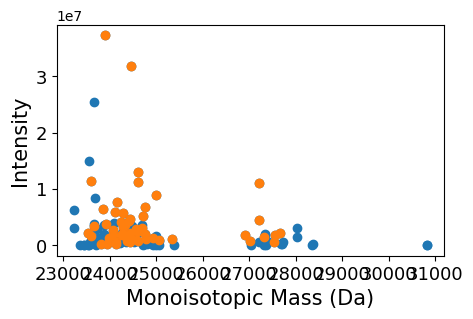

In [17]:
figsize=(5, 3)
fig = plt.figure(figsize=figsize)

dfa, dfb = df_ctrl.copy(), dfms_unique.copy()
vol = dfa.Vol.sum()
# dfa['Relative Intensity'] = dfa.Vol/vol
# dfb['Relative Intensity'] = dfb.Vol/vol
plot_zones(dfa, dfb, y='Vol', ylabel='Intensity', figsize=figsize)
# plot_zones(dfa, dfb, y='Relative Intensity', ylabel='Relative Intensity', figsize=figsize)

fig.tight_layout()
svg_fpath = '../outputs/matched_ctrl.svg'
plt.savefig(svg_fpath, dpi=300, transparent=True)

In [18]:
f = '/content/drive/MyDrive/MLC-Seq-main/statics/total_tRNA_seqs_base.xlsx'
df_seqbase_cca = pd.read_excel(f, sheet_name='CCA')
df_seqbase_cc = pd.read_excel(f, sheet_name='CC')
df_seqbase_c = pd.read_excel(f, sheet_name='C')

In [19]:
for s in [2*M, M, Na, K, -2*M, -1*M, 0]:
    dfm1 = match_dfs_v2(df_seqbase_c, df_ctrl, shift=s, inplace=True, ppm=30, copy_cols=['tRNA'])
    idx = df_ctrl[df_ctrl.Match].index
    df_ctrl.loc[idx, 'Isoform'] = 'C'
    dfm2 = match_dfs_v2(df_seqbase_cca, df_ctrl, shift=s, inplace=True, ppm=30, copy_cols=['tRNA'])
    idx = df_ctrl[df_ctrl.Match].index
    df_ctrl.loc[idx, 'Isoform'] = 'CCA'
    dfm3 = match_dfs_v2(df_seqbase_cc, df_ctrl, shift=s, inplace=True, ppm=30, copy_cols=['tRNA'])
    idx = df_ctrl[df_ctrl.Match].index
    df_ctrl.loc[idx, 'Isoform'] = 'CC'
    dfm1.shape, dfm2.shape, dfm3.shape

In [20]:
dft = df_ctrl.copy()
dft = dft.sort_values('tRNA')
dft = dft.reset_index(drop=True)
dft.index += 1
dft[['Mass', 'RT', 'Vol', 'MatchedMass', 'tRNA', 'PPM', 'Isoform', 'Isoform', 'Sft']].to_excel('/content/drive/MyDrive/MLC-Seq-main/outputs/matched_ctrl.xlsx')

In [22]:
df_matched = df_ctrl[df_ctrl.MatchedMass > 0].copy()
df_matched.head()

,Mass,RT,Vol,RA,FA,RoundedMass,Match,MatchedMass,Sft,tRNA,PPM,Isoform
239,23241.128989,15.399059,6.234534e+06,6.336118,0.586319,23241.0,False,23241.06868,14.01,GlyGCC,2.594930,CC
572,23541.133776,15.800097,2.135535e+06,2.170331,0.200834,23541.0,False,23541.08260,0.00,Glu3UC,2.173920,C
99,23599.158418,15.501625,1.141425e+07,11.600230,1.073439,23599.0,False,23599.08050,0.00,AspGUC,3.301747,C
703,23608.161063,15.447911,1.685355e+06,1.712816,0.158497,23608.0,False,23608.17890,0.00,TrpBCA,0.755563,C
406,23668.199499,16.150452,3.375145e+06,3.430138,0.317411,23668.0,False,23668.16360,0.00,CysGCA,1.516772,C


<Figure size 500x300 with 0 Axes>

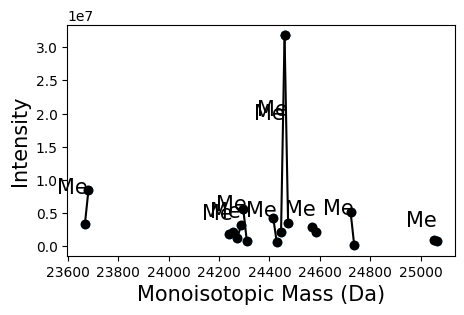

In [23]:

dft = dfms_unique.copy()
bcr = homology_search(df_matched, names=['Me'], ppm=10)

figsize=(5, 3)
fig = plt.figure(figsize=figsize)

plot_basecalling(bcr[0], bcr[1], y='Vol', annotate=False, ylabel='Intensity', plt=plt, figsize=figsize)
plotly_basecalling(*bcr, y='Vol')
fig.tight_layout()
svg_fpath = '/content/drive/MyDrive/MLC-Seq-main/outputs/homology.svg'
plt.savefig(svg_fpath, dpi=300, transparent=True)

# Acid-Deg

In [24]:
path = '/content/drive/MyDrive/MLC-Seq-main/samples/total_tRNA/AcidDeg/'
dir_list = os.listdir(path)
ad_files = [path+f for f in dir_list]
ad_files.sort()

dfs = [load_data(f) for f in ad_files]
df_ad = pd.concat(dfs)
df_ad.shape

(36076, 5)

In [25]:
def load_tRNA_library(f_lib='/content/drive/MyDrive/MLC-Seq-main/statics/total_tRNA_mass_ladders.xlsx'):
    df_lib = pd.read_excel(f_lib, skiprows=1)
    return df_lib


def match_library_extended_ext(df, df_lib, idx, ori=5, ppm=30, col_shifts={}):
    """col_shifts should be like {<idx>: [(K, 'K'), (Na, 'Na'), {H2O, 'Dehydration'}]},
    while <idx> is the index of cols ['5prim_df', '3prim_df', '3prim_CCtailed_df', '3prim_Ctailed_df']
    """
    dfms = list()
    row = df_lib.loc[idx]
    cols = ['5prim_df', '3prim_df', '3prim_CCtailed_df', '3prim_Ctailed_df']
    for col_idx, col in enumerate(cols):
        df_ladder = pd.read_csv(StringIO(row[col]), sep="\t")
        shifts = [0]
        ext_shifts = col_shifts.get(col_idx)
        if ext_shifts:
            s = [i[0] for i in ext_shifts]
            shifts.extend(s)
        dfm_grp = [match_dfs(df_ladder, df, ppm=ppm, shift=shift) for shift in shifts]
        ldl_names = ['Regular']
        if ext_shifts:
            ldl_names.extend([i[1] for i in ext_shifts])
        dfm_grp = list(zip(dfm_grp, ldl_names))
        dfms.append(dfm_grp)
    return dfms

In [26]:
from io import StringIO

rates = list()
df_lib = load_tRNA_library()
for idx, row in df_lib.iterrows():
    row = df_lib.loc[idx]
    data_row = [c for c in row[1:93] if c != '-']

    tRNA_type, *data_row = data_row
    rows = [data_row]

    dfm_grps = match_library_extended_ext(df_ad, df_lib, idx)
    combined_sites = list()
    for grp_id, dfm_grp in enumerate(dfm_grps): # [5´, 3´, 3´-CC, 3´-C]
        for dfm_idx, (dfm, dfm_label) in enumerate(dfm_grp):
            dfm_tmp = dfm.copy()
            dfm_tmp = drop_dups(dfm_tmp)
            if grp_id == 1:
                dfm_tmp.Mass = row['MassCCA'] - dfm_tmp.Mass
            if grp_id == 2:
                dfm_tmp.Mass = row['MassCC'] - dfm_tmp.Mass
            if grp_id == 3:
                dfm_tmp.Mass = row['MassC'] - dfm_tmp.Mass
            sites = dfm_tmp.Mass//320
            combined_sites.extend(sites)
            break

    depth_sites = combined_sites.copy()
    combined_sites = set(combined_sites)
    combined_sites = [i for i in combined_sites if i > 0]
    combined_rate = len(combined_sites)/len(data_row)

    #  Ladder Coverage
    ladder_hits = [len(dfm_grp[0][0]) for dfm_grp in dfm_grps]
    ladder_hits_rate = [h/len(data_row) for h in ladder_hits]
    pie_rates = [[1-r, r] for r in ladder_hits_rate]
    print(idx+1, tRNA_type, f"{combined_rate:.2f}", combined_sites)

1 AlaIGC 0.97 [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 25.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0]
2 Arg1CU 0.92 [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 34.0, 35.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 72.0, 73.0, 74.0, 76.0]
3 Arg1CU 0.91 [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 9.0, 10.0, 11.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 